In [1]:
# Change le répertoire de travail courant
import os
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\OpenClassrooms\\Jupyter")
os.getcwd()

'C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\OpenClassrooms\\Jupyter'

In [2]:
# Rechargement des valeurs nettoyées et complétées
import pandas as pd
data = pd.read_csv("en.openfoodfacts.org.products.completed.csv")
data.shape

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(967012, 52)

#### Analyse univariée ####
Fréquences d'apparition pour les variables catégorielles

In [3]:
groups = data["pnns_groups_1"].unique()
print(groups)

['unknown' 'Composite foods' 'Sugary snacks' 'Fruits and vegetables'
 'Fish Meat Eggs' 'Cereals and potatoes' 'Salty snacks' 'Beverages'
 'Milk and dairy products' 'Fat and sauces' 'Alcoholic beverages']


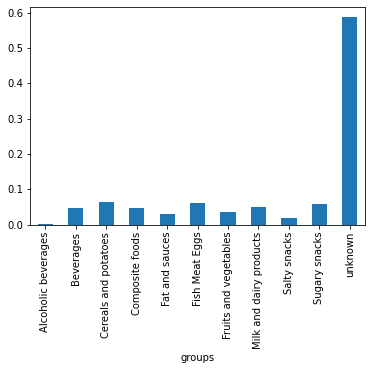

In [4]:
import matplotlib.pyplot as plt
groups_count = data["pnns_groups_1"].value_counts(normalize=True, sort=False).sort_index(ascending=True)
groups_count.plot(kind='bar')
plt.xlabel("groups")
plt.show()

### Les catégories ###
Nous allons examiner les catégories renseignées dans le jeu de données, afin de trouver un découpage de l'ensemble qui nous semble pertinent.

#### Répartition des nutriscores ####

In [5]:
# Reprise des couleurs pour chaque nutriscore
import matplotlib.colors as colors
couleurs = {'a': '#037D3F', 'b': '#81B52E', 'c': '#F6C502', 'd': '#E77D00', 'e': '#DF3C10'}
cmap = colors.ListedColormap(couleurs.values(), name='from_list', N=None)

['a' 'b' 'c' 'd' 'e']


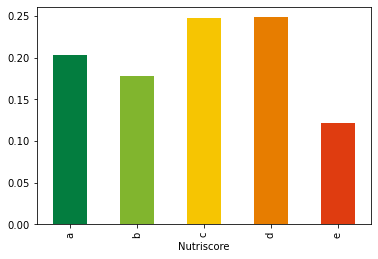

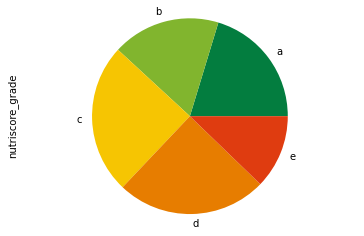

In [6]:
nutriscore_grades = data["nutriscore_grade"].dropna().unique()
nutriscore_grades.sort()
print(nutriscore_grades)

# Diagramme en tuyaux d'orgues pour le nutriscore
def show_nutriscores_bar(grades, xlabel="Nutriscore"):
    sorted_grades = grades.value_counts(normalize=True, sort=False)
    for grade in nutriscore_grades:
        if not grade in sorted_grades.keys():
            sorted_grades[grade] = 0
    sorted_grades = sorted_grades.sort_index(ascending=True)
    sorted_grades.plot(kind='bar', color=cmap.colors)
    plt.xlabel(xlabel)
    plt.show()
    
# Diagramme en camembert pour le nutriscore
def show_nutriscores_pie(grades):
    sorted_grades = grades.value_counts(normalize=True, sort=False).sort_index(ascending=True)
    sorted_grades.plot(kind='pie', cmap=cmap)
    plt.axis('equal') 
    plt.show()

show_nutriscores_bar(data["nutriscore_grade"])
show_nutriscores_pie(data["nutriscore_grade"])

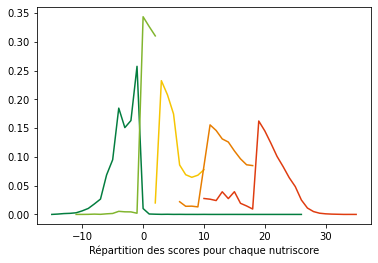

In [7]:
# Diagrammes du nutrition-score-fr_100g pour chaque valeur de nutriscore
for score in nutriscore_grades:
    counts = data[data["nutriscore_grade"] == score]["nutrition-score-fr_100g"].value_counts(normalize=True, sort=False)
    counts.sort_index(ascending=True, inplace=True)
    plt.plot(counts.index.values, counts.values, color=couleurs[score])
plt.xlabel("Répartition des scores pour chaque nutriscore")
plt.show()

Ce graphique vérifie globalement la règle d'attribution des scores trouvée sur internet :

| Score     | Lettre | Couleur |
| :-------- |:------:| :------ |
| -20 à 0	| A	     | Vert foncé |
| 0 à 5	    | B	     | Vert |
| 5 à 10	| C	     | Jaune |
| 10 à 20	| D	     | Orange |
| 20 à 40   | E	     | Orange foncé |

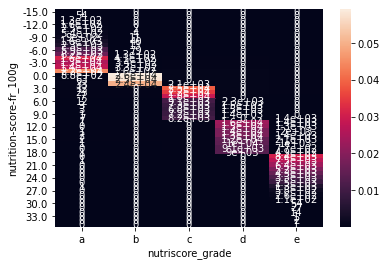

In [8]:
# On vérifie la corrélation entre le "nutrition-score-fr_100g" et le "nutriscore_grade"
X = "nutrition-score-fr_100g"
Y = "nutriscore_grade"
cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

import seaborn as sns

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()

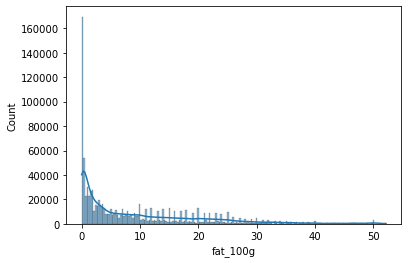

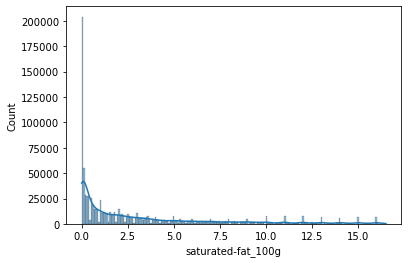

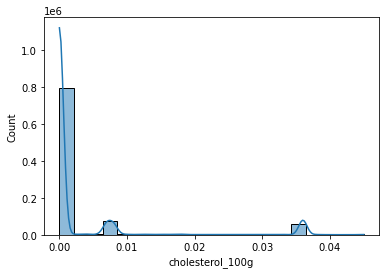

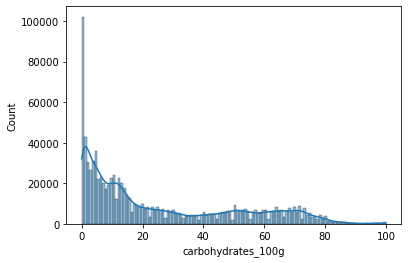

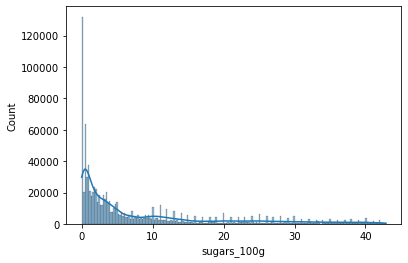

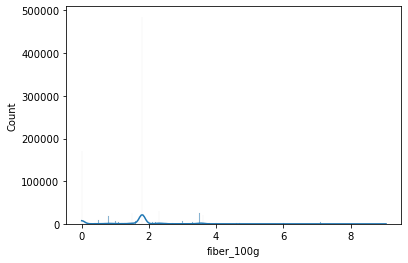

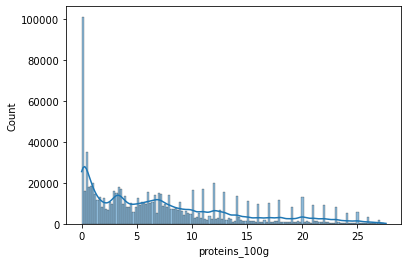

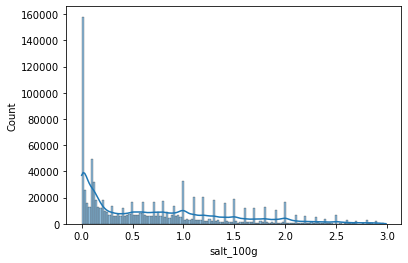

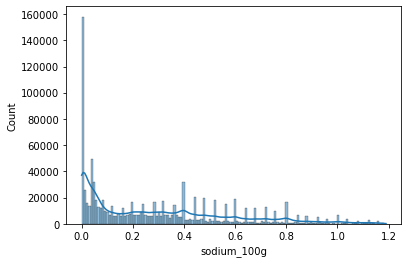

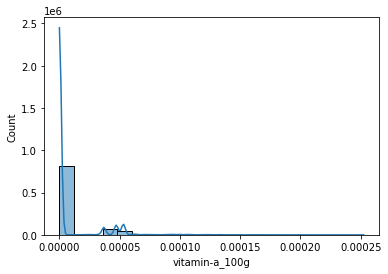

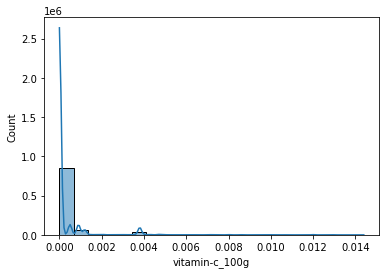

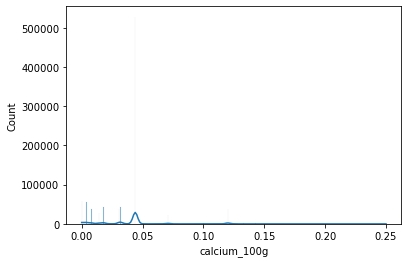

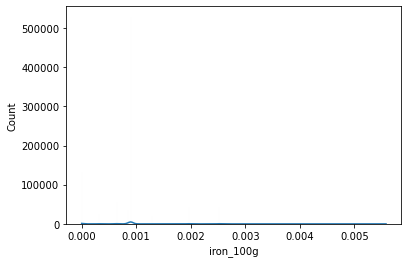

In [9]:
# Pour les valeurs nutritionnelles, on examine leur distribution par des histogrammes
cols_100g = ['fat_100g', 'saturated-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']
for col in cols_100g:
    sns.histplot(x=col, data=data[[col]], kde=True)
    plt.show()

#### Répartition des nutriscores par catégorie ####

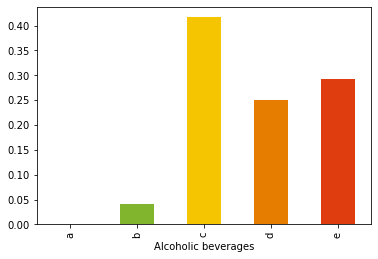

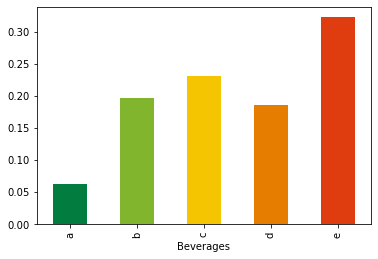

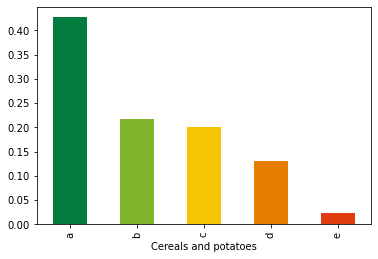

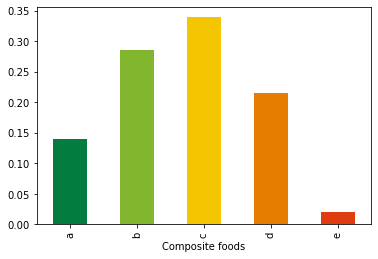

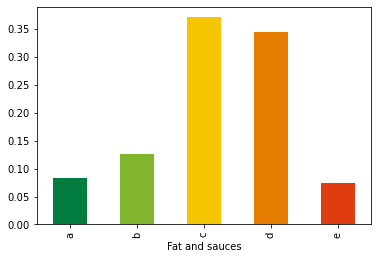

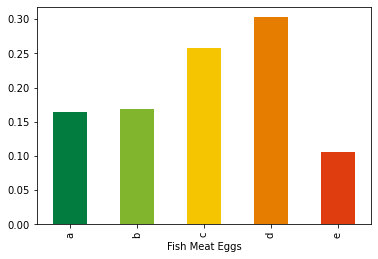

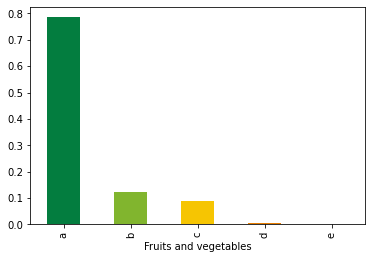

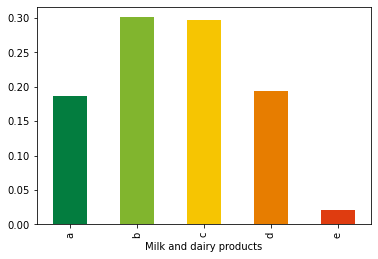

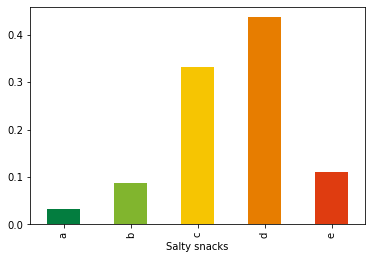

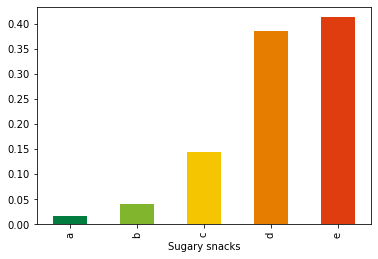

In [10]:
# on s'aperçoit que la colonne "pnns_groups_1" a 2 valeurs semblables : "Sugary snacks" & "sugary-snacks" => on merge
data.loc[(data["pnns_groups_1"] == 'sugary-snacks'),'pnns_groups_1'] = 'Sugary snacks'

# on filtre la catégorie "unknown"
def filter_unknown(g):
    return g != 'unknown'

pnns_groups_1 = []
for pnns_group in filter(filter_unknown, data["pnns_groups_1"].dropna().unique()):
    pnns_groups_1.append(pnns_group)
pnns_groups_1.sort()

# puis on affiche les barplot pour chaque catégorie
for pnns_group in pnns_groups_1:
    show_nutriscores_bar(data[data["pnns_groups_1"] == pnns_group]["nutriscore_grade"], pnns_group)

In [11]:
# On a déterminé précédemment que certaines catégories sont fortement corrélées
# (fruits: bons nutriscores, snacks sucrés: mauvais scores), mais pas toutes.
# On peut vérifier également les moyennes du score qui nous confirment cette corrélation.

def get_grade(score):
    if score < 0:
        return "a"
    elif score < 5:
        return "b"
    elif score < 10:
        return "c"
    elif score < 20:
        return "d"
    else:
        return "e"

for pnns_group in pnns_groups_1:
    nutrition_scores = data[data["pnns_groups_1"] == pnns_group]["nutrition-score-fr_100g"]
    moyenne = nutrition_scores.mean()
    print("Score moyen du groupe", pnns_group, ":", str(round(moyenne, 2)), " - note :", get_grade(moyenne))

Score moyen du groupe Alcoholic beverages : 8.17  - note : c
Score moyen du groupe Beverages : 6.77  - note : c
Score moyen du groupe Cereals and potatoes : 2.27  - note : b
Score moyen du groupe Composite foods : 4.95  - note : b
Score moyen du groupe Fat and sauces : 8.6  - note : c
Score moyen du groupe Fish Meat Eggs : 7.14  - note : c
Score moyen du groupe Fruits and vegetables : -3.04  - note : a
Score moyen du groupe Milk and dairy products : 4.63  - note : b
Score moyen du groupe Salty snacks : 10.7  - note : d
Score moyen du groupe Sugary snacks : 15.86  - note : d


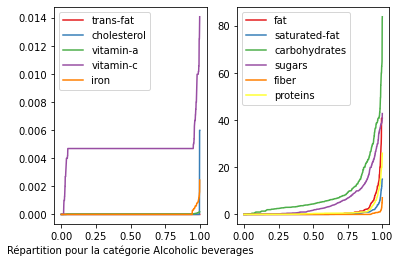

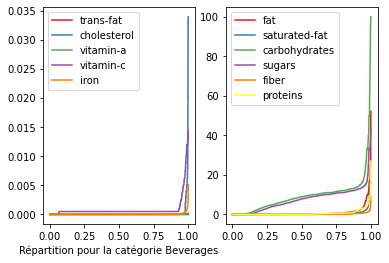

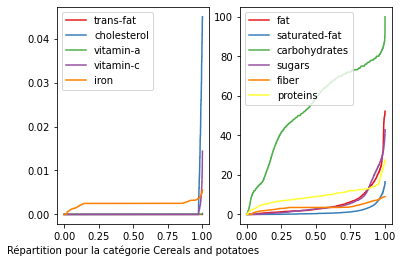

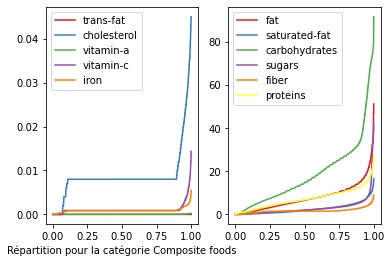

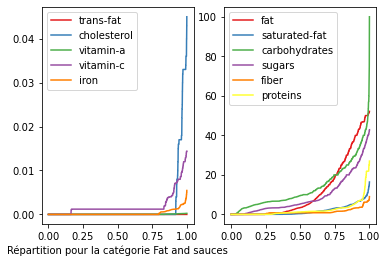

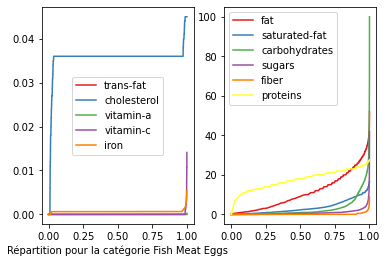

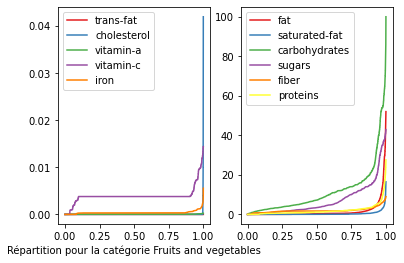

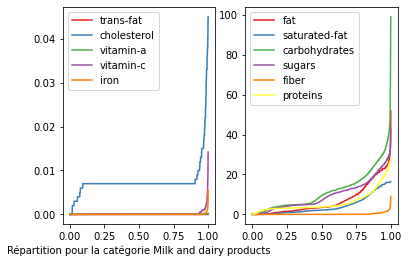

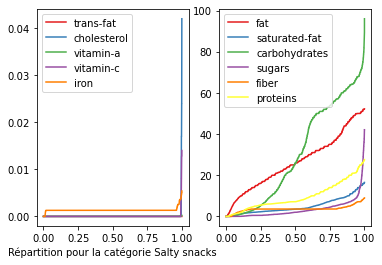

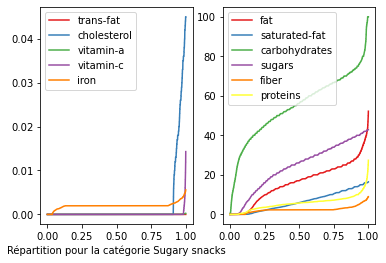

In [12]:
# on divise les valeurs nutritionnelles en 2 groupes, en rapport à l'échelle des valeurs constatées
cols_100g_1 = ['trans-fat_100g', 'cholesterol_100g','vitamin-a_100g', 'vitamin-c_100g', 'iron_100g']
cols_100g_2 = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g']

import numpy as np
import matplotlib.cm as cm
colormap = cm.get_cmap('Set1')

def show_repartition(data, cols, pos, pnns_group, colormap, label):
    i = 0
    plt.subplot(1, 2, pos)
    for ingredient in cols:
        X2 = np.sort(data[data["pnns_groups_1"] == pnns_group][ingredient])
        dim = len(data[data["pnns_groups_1"] == pnns_group])
        F2 = np.array(range(dim))/float(dim)
        plt.plot(F2, X2, color = colormap.colors[i], label = ingredient[:-5])
        i += 1
    plt.legend()
    plt.xlabel(label)
    
# Pour chaque catégorie, on fait 2 graphiques
for pnns_group in pnns_groups_1:
    show_repartition(data, cols_100g_1, 1, pnns_group, colormap, "Répartition pour la catégorie " + pnns_group)
    show_repartition(data, cols_100g_2, 2, pnns_group, colormap, "")
    plt.show()

Les graphiques ci-dessus nous montrent bien la différence de répartition des colonnes nutritionnelles pour chaque catégorie de produits dans nos données.

Pour finir, nous allons faire une analyse sous la forme de boxplots entre les catégories et les colonnes nutritionnelles.

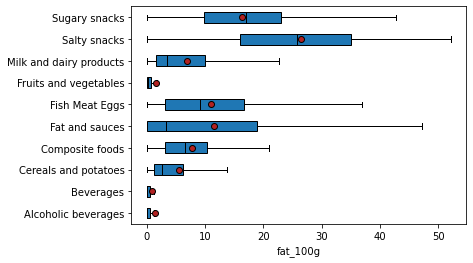

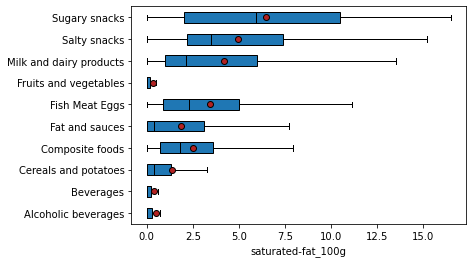

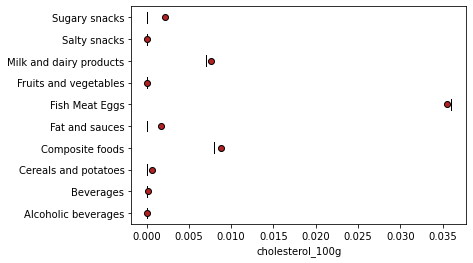

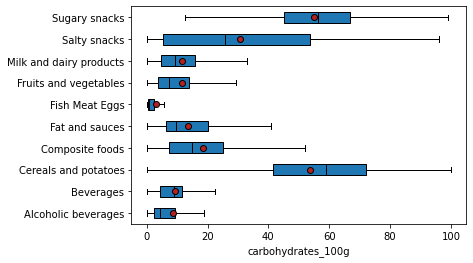

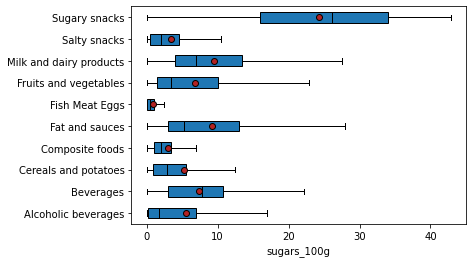

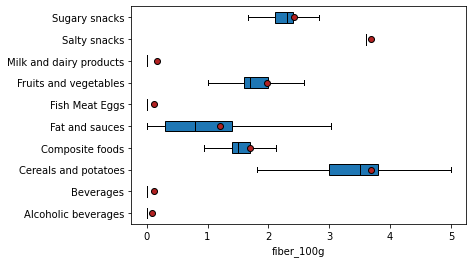

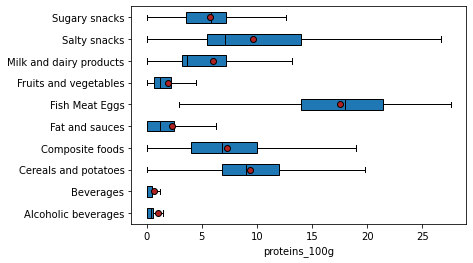

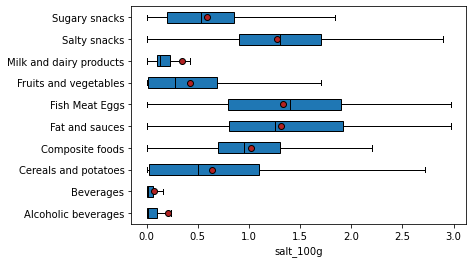

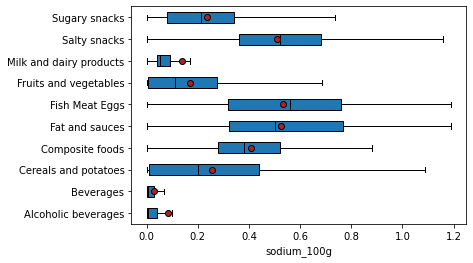

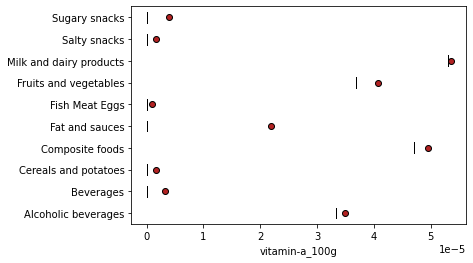

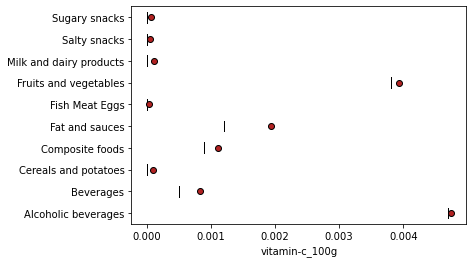

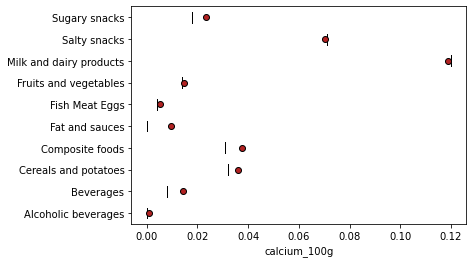

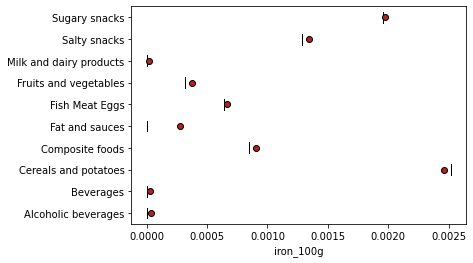

In [13]:
cols_100g = ['fat_100g', 'saturated-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']

def show_boxplots(df, pnns_groups_1, col):
    values = []
    for pnns_group in pnns_groups_1:
        values.append(df[df["pnns_groups_1"] == pnns_group][col])
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}
    plt.boxplot(values, labels=pnns_groups_1, showfliers=False, medianprops=medianprops, 
                vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.xlabel(col)
    plt.show()
    
for col in cols_100g:
    show_boxplots(data[data[col].notna()], pnns_groups_1, col)

Nous allons réaliser le même type d'analyse bivariée entre le nutriscore et les valeurs nutritionnelles :

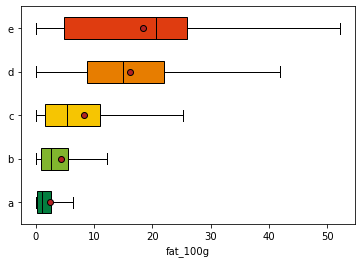

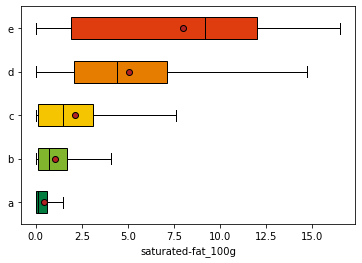

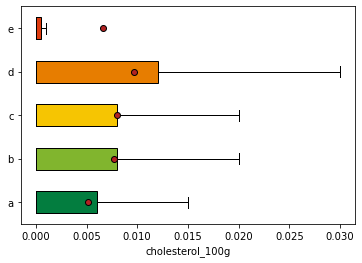

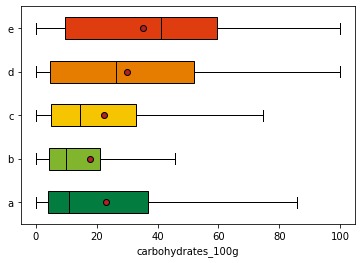

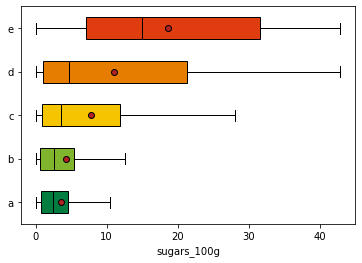

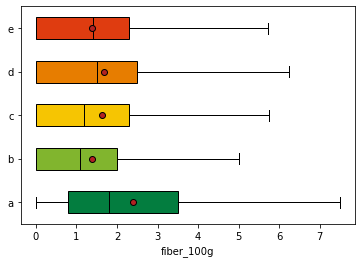

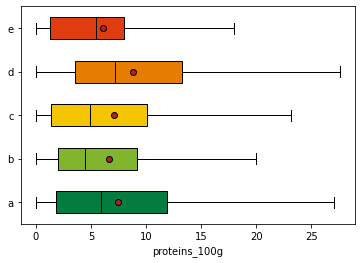

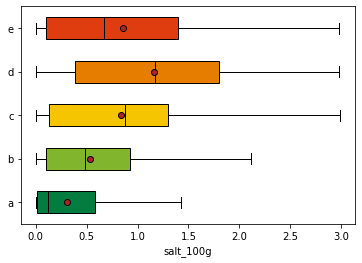

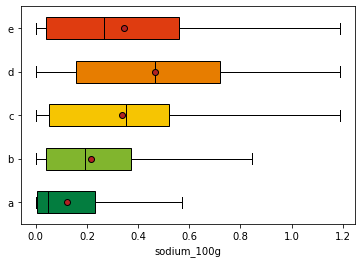

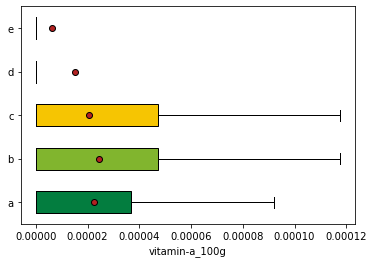

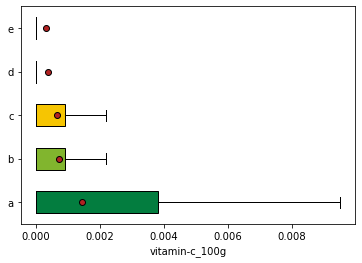

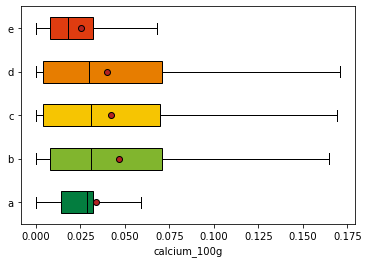

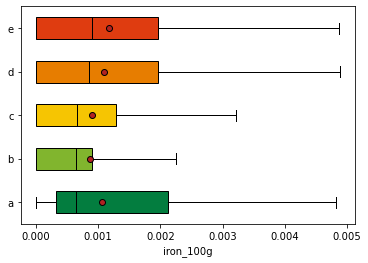

In [14]:
def show_boxplots(df, nutriscore_grades, col):
    values = []
    for nutriscore_grade in nutriscore_grades:
        values.append(df[df["nutriscore_grade"] == nutriscore_grade][col])
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}
    boxplot = plt.boxplot(values, labels=nutriscore_grades, showfliers=False, medianprops=medianprops, 
                vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    i = 0
    for box in boxplot['boxes']:
        box.set(facecolor = list(couleurs.values())[i])
        i += 1
    plt.xlabel(col)
    plt.show()
    
for col in cols_100g:
    show_boxplots(data[data[col].notna()], nutriscore_grades, col)

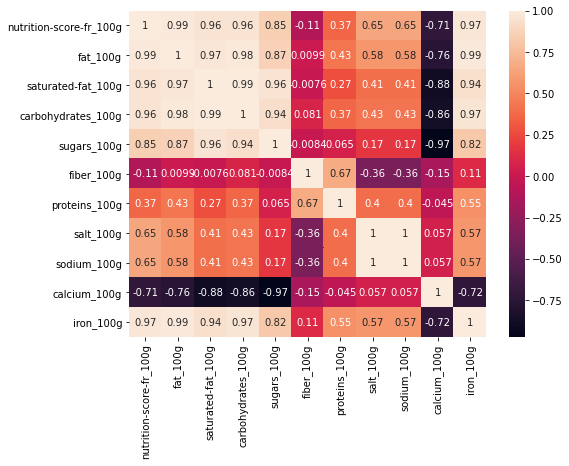

In [15]:
cols = ['nutrition-score-fr_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'calcium_100g', 'iron_100g']
# Affichons la matrice de corrélation entre le nutriscore et les valeurs nutritionnelles :
X = {}
for col in cols:
    Xcol = []
    for grade in nutriscore_grades:
        Xcol.append(data[data['nutriscore_grade'] == grade][col].median())
    X[col] = Xcol
corr_df = pd.DataFrame(X).corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

Nous avons donc une corrélation forte avec certaines valeurs nutritionnelles, et moins importantes avec d'autres.
Nous vérifions ça avec le test Chi-2 :

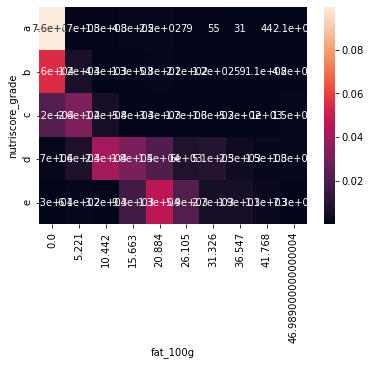

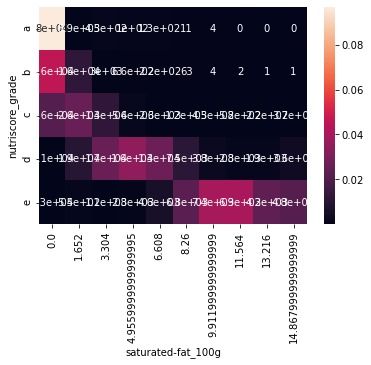

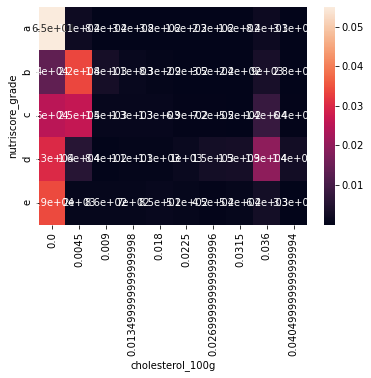

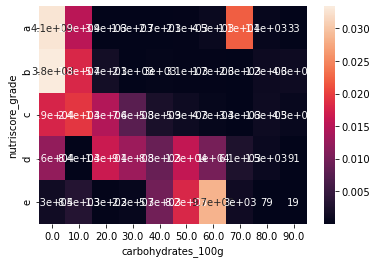

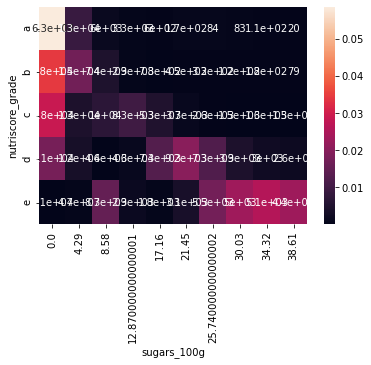

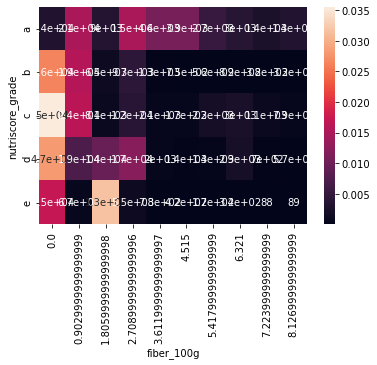

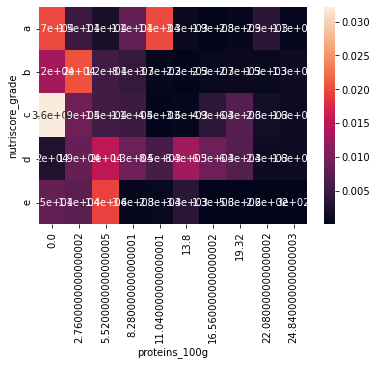

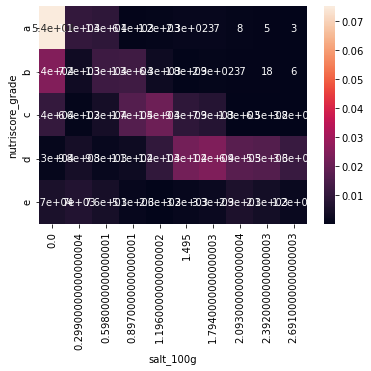

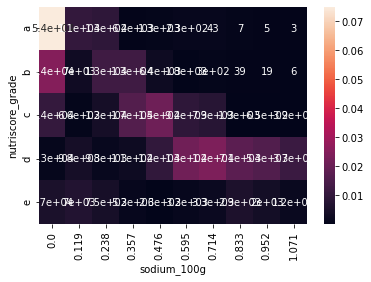

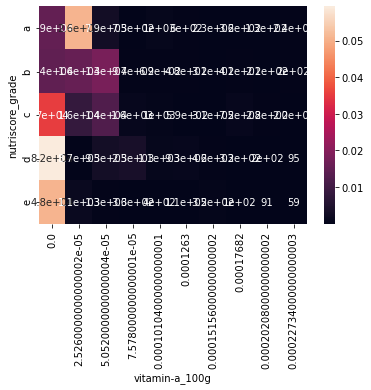

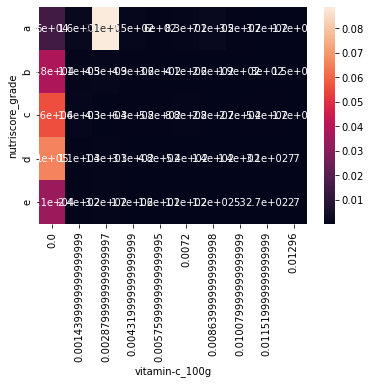

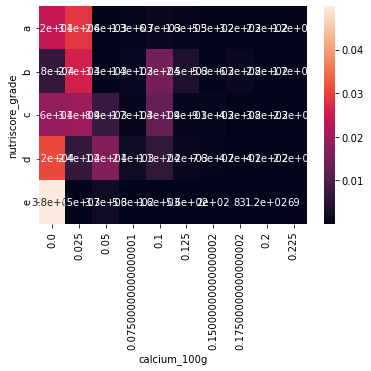

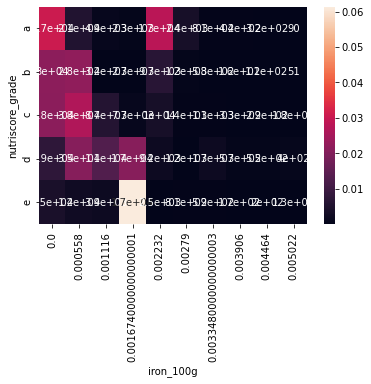

In [16]:
# Pour chaque colonne de valeur nutritionnelle
for col in cols_100g:
    # on découpe les valeurs en tranches
    subset = data[data['nutriscore_grade'].notna()][col]
    tranches = np.arange(0, max(subset), max(subset)/10)
    indices = np.digitize(subset, tranches)
    values_tranches = []
    for i in indices:
        values_tranches.append(tranches[i - 1])
    df = data[data['nutriscore_grade'].notna()][["nutriscore_grade"]]
    df[col] = values_tranches
    
    # on calcule le tableau de contingence
    cont = df[['nutriscore_grade', col]].pivot_table(index='nutriscore_grade',
                                                            columns=col,
                                                            aggfunc=len,margins=True,margins_name="Total")
    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(data)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    
    # calcul du chi-2
    xi_n = measure.sum().sum()
    table = measure/xi_n
    
    # le tableau de contingence coloré
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
    plt.show()

### Réalisation d'une ACP ###

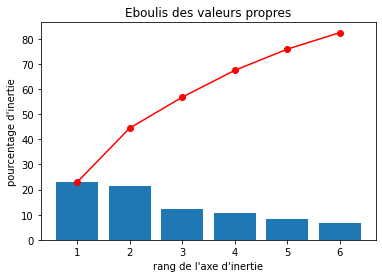

In [17]:
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# choix du nombre de composantes à calculer
n_comp = 6

X = data[data['nutriscore_grade'].notna()][cols_100g].values # uniquement les colonnes des valeurs nutritionnelles

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

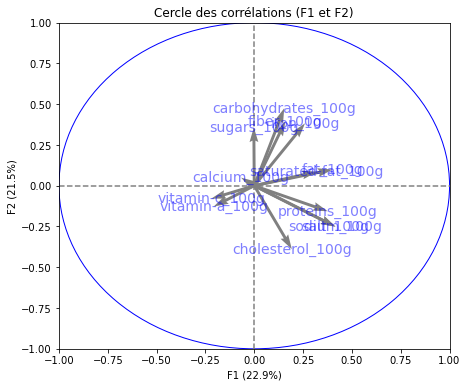

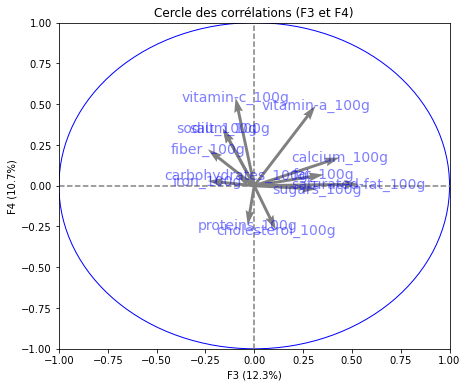

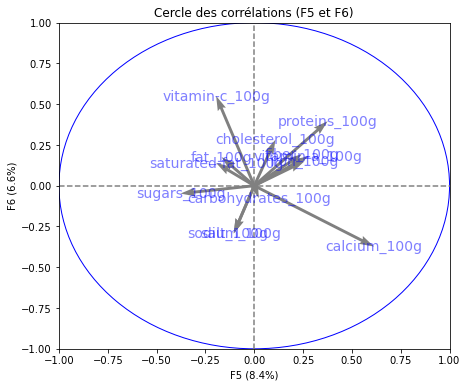

In [18]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(cols_100g))

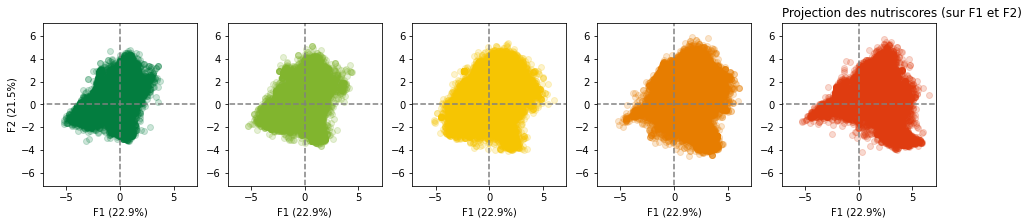

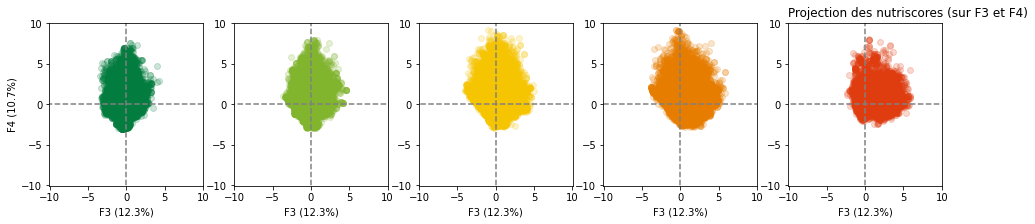

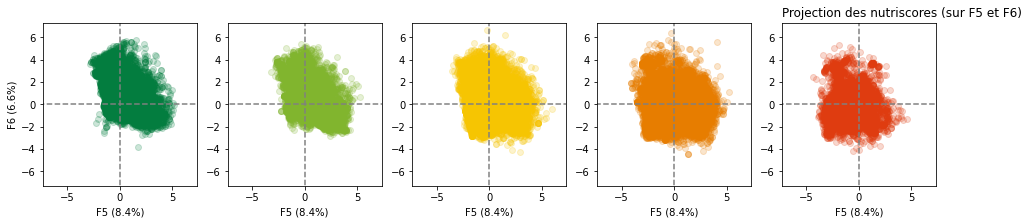

In [81]:
# Projection des individus
X_projected = pca.transform(X_scaled)
nutriscores = data[data['nutriscore_grade'].notna()]['nutriscore_grade']
for d1, d2 in [(0,1),(2,3),(4,5)]:
    if d2 < n_comp:

        # initialisation de la figure       
        fig = plt.figure(figsize=(16, 3))

        # affichage des points
        pos = 1
        for value in np.unique(nutriscores):
            selected = np.where(nutriscores == value)
            plt.subplot(1, 5, pos)
            plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=0.2, label=value, c=couleurs[value])

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            if pos == 1:
                plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            pos += 1

        plt.title("Projection des nutriscores (sur F{} et F{})".format(d1+1, d2+1), loc='left')          
        plt.show(block=False)